In [1]:
pwd

'/home/jdlevy/Documents/GitHub/xai_birds/notebooks'

In [2]:
import os
os.listdir('../models')

['.ipynb_checkpoints',
 'training_objects',
 'has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_13_epoch_state_dict.pth',
 'has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_8_epoch_0.001_lr_state_dict.pth',
 'tmp__has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_270_epoch_state_dict.pth',
 'has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_24_epoch_state_dict.pth',
 'has_bill_shape__has_breast_pattern__species__family_28_epoch_state_dict.pth',
 'has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_4_epoch_0.001_lr_state_dict.pth',
 'has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_1_epoch_state_dict.pth',
 'species__family_27_epoch_state_dict.pth',
 'tmp__has_shape__has_size__species__family_210_epoch_state_dict.pth',
 'tmp__has_bill_shape__has_breast_pattern__has_shape__has_size__species__family_255_epoch_state_dict.pth',
 'has_bill_shape__has_breas

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys
from captum.attr import GuidedGradCam
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

sys.path.insert(0, '../src')
from bird_dataset import *
from models.multi_task_model import *
from XAI_BirdAttribute_dataloader import *

In [2]:
os.chdir('../')

In [3]:
# https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [5]:
# # bd = BirdDataset(preload=True, attr_file='attributes')
# bd = BirdDataset(preload=True, data_dir='../CUB_200_2011/', species_file='classes-families.txt', preload_dir='../processed_data/', preload_file='images-families.pkl')

In [8]:
# '''With inspiration from https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855 and https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086'''

# import torch
# import os
# import PIL.Image as Image
# import pandas as pd
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils, models
# import sys
# import torch.nn as nn
# import torch.nn.functional as F


# sys.path.insert(0, '../src')
# from bird_dataset import *


# class MultiTaskModel(nn.Module):
#     """
#     Creates a MTL model for the two attributes: 'has_bill_shape' and 'has_wing_color'
#     """
#     def __init__(self, model, dataset, ps=0.5):
#         super(MultiTaskModel,self).__init__()
        
# #         num_feats = model.classifier[6].in_features
# #         features = list(model.classifier.children())[:-1]
# #         features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
# #         vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
#         print('hi')
#         self.encoder = model        #fastai function that creates an encoder given an architecture
#         # print(dataset.class_dict)
# #         self.fc1 = nn.Linear(1000, 512)
#         nn.init.xavier_normal_(self.fc1.weight)

# #         self.fc2 = nn.Linear(512, 256)
#         nn.init.xavier_normal_(self.fc2.weight)
#         # self.bn2 = nn.BatchNorm1d(256)
# #         self.fc3 = nn.Linear(256, 256)
#         # self.bn3 = nn.BatchNorm1d(256)
# #         self.dropout = nn.Dropout(0.25)

#         self.dataset = dataset
#         self.fc_dict = {}
#         for key, value in self.dataset.class_dict.items():
# #             setattr(self, key, nn.Linear(256, len(value)))
#             setattr(self, key, nn.Linear(1000, len(value)))

#             # print(f'num_unique_vals in {key}: {len(value)}')
#             self.fc_dict[key] = getattr(self, key)
# #             nn.init.xavier_normal_(getattr(self, key).weight)

#             # self.eval(f'{key}') = nn.Linear(1000, len(value))
#         # self.fc1 = nn.Linear(1000, 9)
#         # self.fc2 = nn.Linear(1000, 15)

#     def forward(self,x, target=None):
#         print('sup')
# #         x = nn.ReLU(self.encoder(x))
#         x = self.encoder(x)

#         # print(x.shape)
# #         x = self.dropout(F.relu(self.fc1(x)))
#         # print(x.shape)
# #         x = self.dropout(F.relu(self.fc2(x)))
#         # print(x.shape)
# #         x = F.relu(self.fc3(x))
#         # print(x.shape)
#         # bill_shape = self.fc1(x)
#         # wing_color = self.fc2(x)
#         ret_vals = [F.softmax(self.fc_dict[key](x), dim=1) for key in self.dataset.class_dict]
# #         if len(ret_vals) == 1:
# #             return ret_vals[0]
#         if target is not None: 
#             print(f'outpt: {self.fc_dict[target](x)}')
#             print(f'softmax outpt: {F.softmax(self.fc_dict[target](x), dim=1)}')
#             print(f'prediction: {torch.max(F.softmax(self.fc_dict[target](x), dim=1), 1)[1]}\n')
#             return self.fc_dict[target](x)
#         return np.array(ret_vals)
    
# class MultiTaskLossWrapper(nn.Module):
#     '''
#     Multi-Task loss for two attributes only
#     '''
#     def __init__(self, dataset):
#         super(MultiTaskLossWrapper, self).__init__()
# #         self.task_num = task_num
# #         self.log_vars = nn.Parameter(torch.zeros((task_num)))
#         self.dataset = dataset
#     def forward(self, preds, labels):

# #         print("PREDICTIONS:",preds)
# #         print("LABELS:",labels)
# # #         print(labels)
# #         print(labels[0].shape)
# #         print(preds[0].shape)
#         labels = labels.reshape(len(self.dataset.class_dict),-1)
#         loss = sum([nn.CrossEntropyLoss()(preds[i], labels[i]) for i in range(len(preds))])

#         #         loss = sum([nn.CrossEntropyLoss()(preds[i].reshape(1, -1), labels[i].reshape(len(self.dataset.class_dict))) for i in range(len(preds))])

# #         loss0 = nn.CrossEntropyLoss()(preds[0].reshape(1, -1), labels[0].reshape(1))
# #         loss1 = nn.CrossEntropyLoss()(preds[1].reshape(1, -1), labels[1].reshape(1))
#         return loss


In [9]:
## TODO turn below cell into a function

In [10]:
# Bird_Attribute_Loader.__init__()

In [12]:
obj_str = 'has_shape__has_size__species__family_0_obj.pkl'

In [14]:
os.chdir('src')

In [15]:
pwd

'/home/jdlevy/Documents/GitHub/xai_birds/src'

In [16]:
with open(f'../models/training_objects/{obj_str}', 'rb') as f:
    mtt = pickle.load(f)

In [17]:
# model = MultiTaskModel(mtt.model, mtt.train_set.dataset)

In [18]:
train_bird_dataset = mtt.train_set
val_bird_dataset = mtt.val_set
model = mtt.model

In [19]:
# # bd = BirdDataset(preload=True, attr_file='attributes')
# vgg16 = models.vgg16_bn(pretrained=False)
# trans = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor()
# ])

# full_dataset = Bird_Attribute_Loader(bd, attrs=None, verbose=False, species=True, transform=trans)
# np.random.seed(42)
# # train_indices = np.random.choice(a=range(len(full_dataset)), size=int(0.8*len(full_dataset)), replace=False)
# train_indices = mtt.train_set.indices
# val_indices = list(set(range(len(full_dataset))) - set(train_indices))
# train_bird_dataset = torch.utils.data.Subset(full_dataset, train_indices)
# val_bird_dataset = torch.utils.data.Subset(full_dataset, val_indices)
# # train_bird_dataset = Bird_Attribute_Loader(bd, attrs=None, verbose=True, species=True, transform=trans, train=True)
# # val_bird_dataset = Bird_Attribute_Loader(bd, attrs=None, verbose=True, species=True, transform=trans, train=False, val=True)
# model = MultiTaskModel(vgg16, full_dataset)
# loss_func = MultiTaskLossWrapper(full_dataset)


# model.eval()
# # batch_size = 4
# trainloader = DataLoader(train_bird_dataset, batch_size=1, shuffle=True)
# valloader = DataLoader(val_bird_dataset, batch_size=1, shuffle=True)

# if torch.cuda.is_available():
#     model.cuda()

In [17]:
# epochs=24
# trans = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])
# train_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape', 'has_breast_pattern', 'has_shape', 'has_size'], species=True, transform=trans, train=True, verbose=True)
# val_bird_dataset = Bird_Attribute_Loader(bd, attrs=['has_bill_shape', 'has_breast_pattern', 'has_shape', 'has_size'], species=True, transform=trans, train=False, val=True, verbose=True)

# label_dict = dict(zip(train_bird_dataset.class_dict.keys(), range(len(train_bird_dataset.class_dict.keys()))))
# task_str = '__'.join(list(train_bird_dataset.class_dict.keys()))

# vgg16 = models.vgg16_bn(pretrained=False)

# model = MultiTaskModel(vgg16, train_bird_dataset)
# model.load_state_dict(torch.load(f'../models/{task_str}_{epochs}_epoch_state_dict.pth'))

# model.eval()
# # batch_size = 4
# trainloader = DataLoader(train_bird_dataset)
# valloader = DataLoader(val_bird_dataset)

# if torch.cuda.is_available():
#     model.cuda()

In [20]:
mtt.label_dict

{'has_shape': 0, 'has_size': 1, 'species': 2, 'family': 3}

In [16]:
# np.where(np.array(val_bird_dataset.ids)==901)

In [17]:
# np.where(np.array(val_bird_dataset.ids)==901)

In [21]:
val_bird_dataset

In [22]:
def gradCAM_model(model, idx, model_name):
#         last_conv = model.encoder.encoder.features[40]
        last_conv = model.encoder.features[40]


#         model.fc1 = nn.Linear(1000, 1000)
#         # nn.init.xavier_normal_(self.fc1.weight)

#         model.fc2 = nn.Linear(1000, 1000)
#         # nn.init.xavier_normal_(self.fc2.weight)
#         # self.bn2 = nn.BatchNorm1d(256)
#         model.fc3 = nn.Linear(1000, 1000)
#         # self.bn3 = nn.BatchNorm1d(256)
#         model.dropout = nn.Dropout(0.25)
#         model.cuda()
        gc = GuidedGradCam(model, last_conv)
        samp = val_bird_dataset[idx]
        print(val_bird_dataset[idx])
        # samp = iter(valloader).next()
        target_idx = mtt.label_dict[model_name]
        img, label = samp['image'].cuda(), torch.LongTensor([samp['labels'][target_idx]]).cuda()
        img = img.expand((1, 3, 224, 224))
#         print(type(img))
        print(f'label: {label}')
#         print(label.size())

        gc_img = gc.attribute(img, label, additional_forward_args=target_idx)
        print(f'target_idx: {target_idx}')
        
#         print(gc_img)
#         gc_img+=0.0001
        # create custom colormap for visualizing the result
        default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                         [(0, '#ffffff'),
                                                          (0.25, '#000000'),
                                                          (1, '#000000')], N=256)


        # visualize the results using the visualize_image_attr helper method
        x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                     methods=["original_image", "heat_map"],
                                     signs=['all', 'positive'],
                                     cmap=default_cmap,
                                     show_colorbar=True)
        if os.path.exists(f'figures/{mtt.task_str}')==False: os.mkdir(f'../figures/{mtt.task_str}')
        x[0].savefig(f'figures/{mtt.task_str}/grad_cam_{model_name}_{idx}.png')

In [82]:
# model

In [58]:
# bd.images[901]

In [71]:
pwd

'/home/jdlevy/Documents/GitHub/xai_birds/notebooks'

In [26]:
# sys.path.insert(0, '..')

In [23]:
os.chdir('../')

In [24]:
mtt.label_dict

{'has_shape': 0, 'has_size': 1, 'species': 2, 'family': 3}

In [25]:
mtt.model.fc_dict

{'has_shape': Linear(in_features=256, out_features=14, bias=True),
 'has_size': Linear(in_features=256, out_features=5, bias=True),
 'species': Linear(in_features=256, out_features=167, bias=True),
 'family': Linear(in_features=256, out_features=37, bias=True)}

In [121]:
mtt.valloader

In [125]:
import copy

In [147]:
sample = copy.deepcopy(val_bird_dataset[1])

sample['image'] = sample['image'].reshape(1, 3, 224, 224)
sample['labels'] = sample['labels'].reshape(1, 4)

In [148]:
# sample = iter(mtt.valloader).next()

In [149]:
sample

{'image': tensor([[[[0.3490, 0.3569, 0.3490,  ..., 0.2314, 0.1961, 0.1647],
           [0.3451, 0.3529, 0.3373,  ..., 0.2275, 0.2000, 0.1725],
           [0.3490, 0.3490, 0.3294,  ..., 0.2235, 0.2000, 0.1686],
           ...,
           [0.3961, 0.3686, 0.3373,  ..., 0.1882, 0.1765, 0.1608],
           [0.4000, 0.3725, 0.3373,  ..., 0.1804, 0.1647, 0.1608],
           [0.4039, 0.3843, 0.3451,  ..., 0.1647, 0.1569, 0.1490]],
 
          [[0.3490, 0.3529, 0.3451,  ..., 0.2039, 0.1804, 0.1529],
           [0.3451, 0.3529, 0.3333,  ..., 0.2000, 0.1765, 0.1529],
           [0.3490, 0.3490, 0.3255,  ..., 0.2078, 0.1804, 0.1529],
           ...,
           [0.3804, 0.3608, 0.3255,  ..., 0.1882, 0.1765, 0.1608],
           [0.3843, 0.3647, 0.3255,  ..., 0.1804, 0.1686, 0.1529],
           [0.3922, 0.3725, 0.3294,  ..., 0.1686, 0.1529, 0.1412]],
 
          [[0.3490, 0.3529, 0.3176,  ..., 0.1529, 0.1373, 0.1137],
           [0.3529, 0.3490, 0.2941,  ..., 0.1451, 0.1294, 0.1059],
           [0.3

In [150]:
# corr_dict = dict()
corr_dict = dict(zip(range(len(mtt.val_set.dataset.class_dict)), np.zeros(len(mtt.val_set.dataset.class_dict))))



val_inputs, val_labels = sample['image'].cuda(), torch.LongTensor(sample['labels']).cuda()
val_outputs = mtt.model(val_inputs.to(mtt.device))
val_predicted = np.array([int(torch.max(i, 1)[1].cpu()) for i in val_outputs])
# val_predicted = np.array([int(i.cpu()) for i in val_predicted])
val_losses = mtt.loss_func(val_outputs, val_labels).item()

val_labels = np.array(val_labels.cpu()).flatten()#.reshape(len(mtt.val_set.dataset.class_dict), -1)
# val_labels = val_predicted
corr_vals = np.where(val_labels==val_predicted)
idx_corr = corr_vals[0]

for j in idx_corr:
    corr_dict[j] += 1

In [151]:
val_losses

11.444198608398438

In [152]:
val_labels

array([13,  1, 63,  0])

In [153]:
val_predicted

array([ 13,   1, 162,   1])

In [154]:
bd = mtt.train_set.dataset.bd

In [155]:
class_dict = mtt.train_set.dataset.class_dict

In [156]:
rev_label_dict = {v:k for k, v in mtt.label_dict.items()}

In [157]:
rev_class_dict = {k:{a:b for b, a in v.items()} for k, v in class_dict.items()}
rev_class_dict['species'] ={v:k for k, v in rev_class_dict['species'].items()}
rev_class_dict['family'] ={v:k for k, v in rev_class_dict['family'].items()}

In [159]:
val_label_names = dict()
for idx, i in enumerate(val_labels):
    task = rev_label_dict[idx]
    label = rev_class_dict[task][i]
    val_label_names[task] = (label)
    
    

val_pred_names = dict()
for idx, i in enumerate(val_predicted):
    task = rev_label_dict[idx]
    label = rev_class_dict[task][i]
    val_pred_names[task] = (label)

In [160]:
val_label_names

{'has_shape': 'has_shape::perching-like',
 'has_size': 'has_size::small_(5_-_9_in)',
 'species': 'Nashville_Warbler',
 'family': 'Warbler'}

In [161]:
val_pred_names

{'has_shape': 'has_shape::perching-like',
 'has_size': 'has_size::small_(5_-_9_in)',
 'species': 'Orange_crowned_Warbler',
 'family': 'Sparrow'}

In [167]:
model_name = 'has_size'

<generator object Module.named_children at 0x7fbb787a9bf8>

In [185]:
last_conv = model.encoder.features[40]


#         model.fc1 = nn.Linear(1000, 1000)
#         # nn.init.xavier_normal_(self.fc1.weight)

#         model.fc2 = nn.Linear(1000, 1000)
#         # nn.init.xavier_normal_(self.fc2.weight)
#         # self.bn2 = nn.BatchNorm1d(256)
#         model.fc3 = nn.Linear(1000, 1000)
#         # self.bn3 = nn.BatchNorm1d(256)
#         model.dropout = nn.Dropout(0.25)
#         model.cuda()
gc = GuidedGradCam(model, last_conv)
samp = val_bird_dataset[idx]
print(val_bird_dataset[idx])
# samp = iter(valloader).next()
target_idx = mtt.label_dict[model_name]
img, label = samp['image'].cuda(), torch.LongTensor([samp['labels'][target_idx]]).cuda()
img = img.expand((1, 3, 224, 224))
#         print(type(img))
print(f'label: {label}')
#         print(label.size())

gc_img = gc.attribute(img, label, additional_forward_args=target_idx)
print(f'target_idx: {target_idx}')

#         print(gc_img)
#         gc_img+=0.0001
# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
x = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)
print(gc_img)

{'image': tensor([[[0.9490, 0.9569, 0.9608,  ..., 0.9569, 0.9529, 0.9569],
         [0.9412, 0.9490, 0.9490,  ..., 0.9647, 0.9529, 0.9569],
         [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9569, 0.9569],
         ...,
         [0.8275, 0.8235, 0.8392,  ..., 0.8627, 0.8784, 0.8667],
         [0.8314, 0.8471, 0.8510,  ..., 0.8784, 0.8863, 0.8745],
         [0.8392, 0.8392, 0.8471,  ..., 0.8549, 0.8627, 0.8627]],

        [[0.9569, 0.9647, 0.9686,  ..., 0.9608, 0.9569, 0.9608],
         [0.9490, 0.9569, 0.9569,  ..., 0.9686, 0.9569, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9569, 0.9608, 0.9608],
         ...,
         [0.8275, 0.8157, 0.8157,  ..., 0.8275, 0.8431, 0.8353],
         [0.8235, 0.8353, 0.8314,  ..., 0.8471, 0.8510, 0.8431],
         [0.8275, 0.8196, 0.8196,  ..., 0.8275, 0.8392, 0.8431]],

        [[0.9529, 0.9608, 0.9647,  ..., 0.9686, 0.9647, 0.9686],
         [0.9451, 0.9529, 0.9529,  ..., 0.9765, 0.9647, 0.9686],
         [0.9569, 0.9569, 0.9569,  ..., 0.9647, 

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 7.79 GiB total capacity; 2.51 GiB already allocated; 95.19 MiB free; 310.50 MiB cached)

In [164]:
# # for i in range(10):
# gradCAM_model(mtt.model, 1, 'has_shape')

In [116]:
pwd

'/home/jdlevy/Documents/GitHub/xai_birds'

{'image': tensor([[[0.7412, 0.7412, 0.7451,  ..., 0.7451, 0.7412, 0.7412],
         [0.7412, 0.7412, 0.7451,  ..., 0.7451, 0.7412, 0.7412],
         [0.7451, 0.7451, 0.7451,  ..., 0.7451, 0.7490, 0.7490],
         ...,
         [0.7843, 0.7686, 0.7608,  ..., 0.7412, 0.7412, 0.7412],
         [0.8000, 0.7961, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
         [0.7804, 0.7882, 0.8078,  ..., 0.7412, 0.7412, 0.7412]],

        [[0.7961, 0.7961, 0.8000,  ..., 0.8000, 0.8000, 0.8000],
         [0.7961, 0.7961, 0.8000,  ..., 0.8000, 0.8039, 0.8039],
         [0.8000, 0.8000, 0.8000,  ..., 0.8000, 0.8000, 0.8000],
         ...,
         [0.7216, 0.7255, 0.7255,  ..., 0.8000, 0.8000, 0.7961],
         [0.7176, 0.7216, 0.7137,  ..., 0.8000, 0.8039, 0.8000],
         [0.6902, 0.7059, 0.7137,  ..., 0.8000, 0.8039, 0.8000]],

        [[0.9020, 0.9020, 0.9059,  ..., 0.9059, 0.9059, 0.9059],
         [0.9020, 0.9020, 0.9059,  ..., 0.9059, 0.9059, 0.9059],
         [0.9059, 0.9059, 0.9059,  ..., 0.9059, 

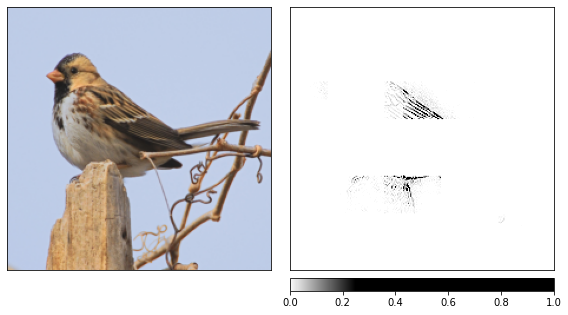

{'image': tensor([[[0.0941, 0.1294, 0.2118,  ..., 0.3843, 0.2588, 0.2000],
         [0.0784, 0.1216, 0.2157,  ..., 0.2745, 0.1922, 0.1333],
         [0.0824, 0.1255, 0.2353,  ..., 0.1725, 0.1255, 0.1216],
         ...,
         [0.2431, 0.2588, 0.2471,  ..., 0.1922, 0.1961, 0.2000],
         [0.1725, 0.1922, 0.2000,  ..., 0.1725, 0.1686, 0.1804],
         [0.1373, 0.1490, 0.1647,  ..., 0.1686, 0.1490, 0.1412]],

        [[0.1294, 0.1686, 0.2078,  ..., 0.3490, 0.2314, 0.1686],
         [0.1176, 0.1608, 0.2157,  ..., 0.2235, 0.1608, 0.1098],
         [0.1098, 0.1529, 0.2196,  ..., 0.1176, 0.0667, 0.0784],
         ...,
         [0.3373, 0.3176, 0.3137,  ..., 0.2000, 0.2118, 0.2157],
         [0.2392, 0.2510, 0.2627,  ..., 0.1804, 0.1922, 0.1961],
         [0.1882, 0.1961, 0.2157,  ..., 0.1804, 0.1843, 0.1725]],

        [[0.0863, 0.1137, 0.1804,  ..., 0.3255, 0.2000, 0.1373],
         [0.0627, 0.1020, 0.1843,  ..., 0.1922, 0.1333, 0.0824],
         [0.0627, 0.1020, 0.2000,  ..., 0.0784, 

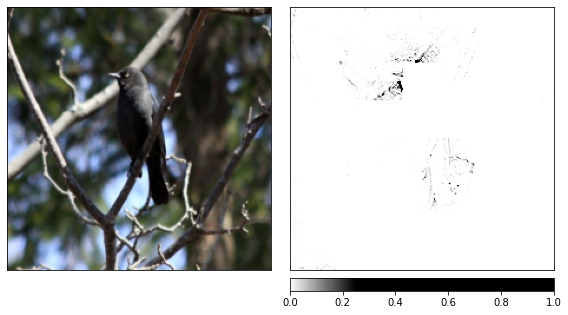

{'image': tensor([[[0.6627, 0.6745, 0.6784,  ..., 0.6627, 0.6667, 0.6706],
         [0.6588, 0.6706, 0.6745,  ..., 0.6667, 0.6667, 0.6667],
         [0.6588, 0.6667, 0.6667,  ..., 0.6706, 0.6706, 0.6667],
         ...,
         [0.4667, 0.4667, 0.4627,  ..., 0.4941, 0.4902, 0.4863],
         [0.4706, 0.4706, 0.4706,  ..., 0.4941, 0.4902, 0.4824],
         [0.4706, 0.4824, 0.4824,  ..., 0.4980, 0.4902, 0.4824]],

        [[0.4863, 0.4824, 0.4902,  ..., 0.4667, 0.4667, 0.4627],
         [0.4824, 0.4824, 0.4863,  ..., 0.4706, 0.4706, 0.4706],
         [0.4784, 0.4784, 0.4824,  ..., 0.4706, 0.4706, 0.4667],
         ...,
         [0.3294, 0.3294, 0.3294,  ..., 0.3490, 0.3490, 0.3490],
         [0.3373, 0.3294, 0.3333,  ..., 0.3451, 0.3451, 0.3412],
         [0.3412, 0.3373, 0.3412,  ..., 0.3451, 0.3451, 0.3373]],

        [[0.3569, 0.3608, 0.3686,  ..., 0.3373, 0.3294, 0.3294],
         [0.3608, 0.3647, 0.3686,  ..., 0.3333, 0.3333, 0.3294],
         [0.3569, 0.3529, 0.3569,  ..., 0.3294, 

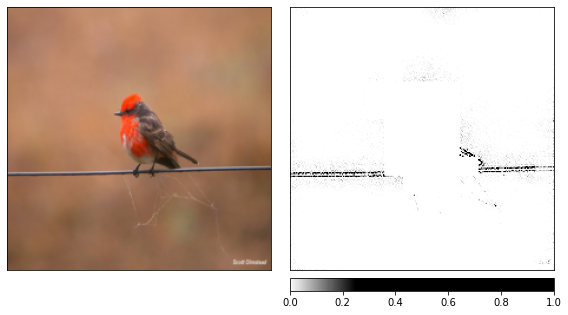

{'image': tensor([[[0.1529, 0.1529, 0.1647,  ..., 0.0235, 0.0314, 0.0353],
         [0.1569, 0.1608, 0.1686,  ..., 0.0157, 0.0196, 0.0275],
         [0.1490, 0.1529, 0.1569,  ..., 0.0157, 0.0157, 0.0157],
         ...,
         [0.0549, 0.0510, 0.0588,  ..., 0.0157, 0.0157, 0.0157],
         [0.0431, 0.0471, 0.0549,  ..., 0.0157, 0.0157, 0.0118],
         [0.0314, 0.0392, 0.0431,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.1765, 0.1725, 0.1725,  ..., 0.0353, 0.0353, 0.0431],
         [0.1725, 0.1725, 0.1647,  ..., 0.0235, 0.0196, 0.0314],
         [0.1686, 0.1725, 0.1686,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.0588, 0.0510, 0.0588,  ..., 0.0196, 0.0157, 0.0157],
         [0.0471, 0.0510, 0.0549,  ..., 0.0157, 0.0157, 0.0118],
         [0.0392, 0.0471, 0.0431,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.1843, 0.1922, 0.1882,  ..., 0.0196, 0.0275, 0.0353],
         [0.1725, 0.1804, 0.1882,  ..., 0.0118, 0.0157, 0.0235],
         [0.1725, 0.1804, 0.1922,  ..., 0.0118, 

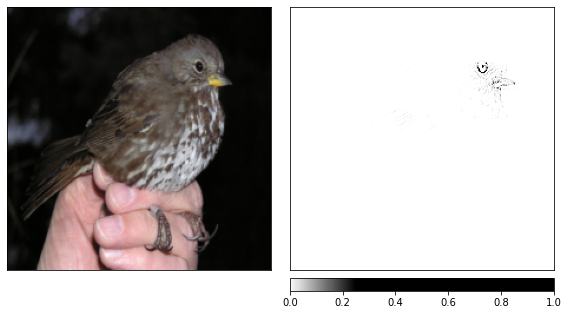

{'image': tensor([[[0.8196, 0.8353, 0.8471,  ..., 0.8706, 0.8588, 0.8588],
         [0.8235, 0.8392, 0.8471,  ..., 0.8706, 0.8588, 0.8549],
         [0.8196, 0.8353, 0.8471,  ..., 0.8627, 0.8588, 0.8588],
         ...,
         [0.9725, 0.9725, 0.9765,  ..., 0.9804, 0.9804, 0.9804],
         [0.9725, 0.9725, 0.9765,  ..., 0.9804, 0.9804, 0.9804],
         [0.9765, 0.9765, 0.9765,  ..., 0.9804, 0.9843, 0.9843]],

        [[0.7922, 0.8039, 0.8118,  ..., 0.8941, 0.8863, 0.8863],
         [0.7961, 0.8039, 0.8118,  ..., 0.8902, 0.8863, 0.8824],
         [0.7882, 0.8039, 0.8078,  ..., 0.8941, 0.8863, 0.8863],
         ...,
         [0.9686, 0.9686, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
         [0.9686, 0.9686, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
         [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9804, 0.9804]],

        [[0.7608, 0.7804, 0.7843,  ..., 0.8941, 0.8784, 0.8706],
         [0.7569, 0.7804, 0.7843,  ..., 0.8980, 0.8863, 0.8784],
         [0.7490, 0.7725, 0.7843,  ..., 0.8941, 

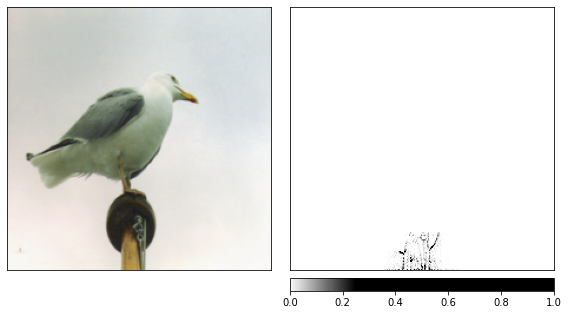

{'image': tensor([[[0.7333, 0.7333, 0.7255,  ..., 0.7020, 0.6941, 0.6824],
         [0.7333, 0.7333, 0.7294,  ..., 0.7020, 0.6824, 0.6706],
         [0.7294, 0.7255, 0.7294,  ..., 0.7020, 0.6784, 0.6588],
         ...,
         [0.7176, 0.7216, 0.7294,  ..., 0.7412, 0.7373, 0.7490],
         [0.7137, 0.7216, 0.7216,  ..., 0.7294, 0.7294, 0.7373],
         [0.7176, 0.7176, 0.7176,  ..., 0.7176, 0.7098, 0.7176]],

        [[0.7098, 0.7020, 0.6941,  ..., 0.6824, 0.6784, 0.6627],
         [0.7137, 0.6941, 0.6902,  ..., 0.6824, 0.6627, 0.6510],
         [0.7059, 0.6863, 0.6824,  ..., 0.6784, 0.6549, 0.6392],
         ...,
         [0.6863, 0.6902, 0.6941,  ..., 0.7294, 0.7255, 0.7333],
         [0.6863, 0.6863, 0.6863,  ..., 0.7176, 0.7216, 0.7294],
         [0.6902, 0.6863, 0.6824,  ..., 0.7059, 0.7059, 0.7137]],

        [[0.6667, 0.6588, 0.6549,  ..., 0.6667, 0.6510, 0.6392],
         [0.6667, 0.6549, 0.6549,  ..., 0.6588, 0.6392, 0.6275],
         [0.6588, 0.6471, 0.6471,  ..., 0.6588, 

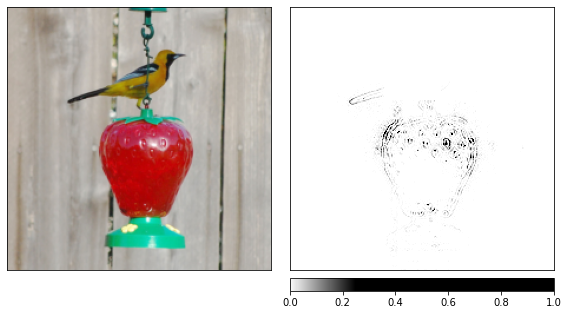

{'image': tensor([[[0.6353, 0.6275, 0.6235,  ..., 0.6078, 0.6000, 0.5961],
         [0.6314, 0.6314, 0.6314,  ..., 0.6078, 0.6118, 0.6078],
         [0.6314, 0.6353, 0.6314,  ..., 0.6118, 0.6196, 0.6235],
         ...,
         [0.6745, 0.6667, 0.6627,  ..., 0.6627, 0.6588, 0.6588],
         [0.6745, 0.6706, 0.6784,  ..., 0.6627, 0.6627, 0.6549],
         [0.6745, 0.6745, 0.6784,  ..., 0.6627, 0.6588, 0.6588]],

        [[0.8039, 0.8000, 0.7961,  ..., 0.7961, 0.7961, 0.7882],
         [0.8039, 0.8039, 0.8000,  ..., 0.7961, 0.8000, 0.8000],
         [0.8039, 0.8039, 0.8000,  ..., 0.8000, 0.8000, 0.8000],
         ...,
         [0.8157, 0.8157, 0.8157,  ..., 0.8157, 0.8118, 0.8118],
         [0.8157, 0.8157, 0.8196,  ..., 0.8157, 0.8157, 0.8078],
         [0.8157, 0.8157, 0.8196,  ..., 0.8157, 0.8118, 0.8118]],

        [[0.9412, 0.9412, 0.9373,  ..., 0.9451, 0.9451, 0.9255],
         [0.9412, 0.9412, 0.9373,  ..., 0.9451, 0.9529, 0.9412],
         [0.9412, 0.9412, 0.9373,  ..., 0.9490, 

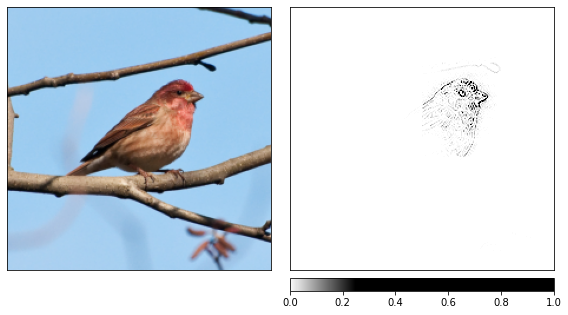

{'image': tensor([[[0.5137, 0.5176, 0.5098,  ..., 0.3373, 0.3451, 0.3608],
         [0.5059, 0.5137, 0.5020,  ..., 0.3176, 0.3333, 0.3490],
         [0.4863, 0.4980, 0.5020,  ..., 0.2902, 0.3137, 0.3294],
         ...,
         [0.3059, 0.3216, 0.3059,  ..., 0.3961, 0.3451, 0.4000],
         [0.3137, 0.3176, 0.3059,  ..., 0.3373, 0.4314, 0.4196],
         [0.3176, 0.3137, 0.3137,  ..., 0.4588, 0.4980, 0.4980]],

        [[0.4314, 0.4353, 0.4275,  ..., 0.3098, 0.3176, 0.3333],
         [0.4235, 0.4314, 0.4196,  ..., 0.2941, 0.3059, 0.3216],
         [0.4039, 0.4157, 0.4196,  ..., 0.2667, 0.2863, 0.3020],
         ...,
         [0.2667, 0.2824, 0.2667,  ..., 0.3529, 0.3020, 0.3569],
         [0.2745, 0.2784, 0.2667,  ..., 0.2941, 0.3882, 0.3765],
         [0.2784, 0.2745, 0.2745,  ..., 0.4157, 0.4549, 0.4549]],

        [[0.3490, 0.3529, 0.3451,  ..., 0.2706, 0.2784, 0.2941],
         [0.3412, 0.3490, 0.3373,  ..., 0.2510, 0.2667, 0.2824],
         [0.3216, 0.3333, 0.3373,  ..., 0.2235, 

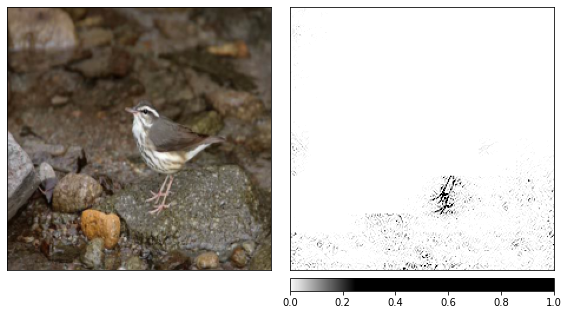

{'image': tensor([[[0.2275, 0.2353, 0.2431,  ..., 0.2235, 0.2235, 0.2235],
         [0.2353, 0.2353, 0.2392,  ..., 0.2275, 0.2314, 0.2314],
         [0.2392, 0.2353, 0.2431,  ..., 0.2275, 0.2353, 0.2392],
         ...,
         [0.4941, 0.4941, 0.4902,  ..., 0.2235, 0.3020, 0.4314],
         [0.4353, 0.4510, 0.4745,  ..., 0.2157, 0.2863, 0.4196],
         [0.3686, 0.3961, 0.4353,  ..., 0.2039, 0.2667, 0.4078]],

        [[0.2902, 0.2941, 0.2941,  ..., 0.2667, 0.2745, 0.2745],
         [0.2980, 0.2941, 0.2902,  ..., 0.2667, 0.2745, 0.2784],
         [0.3020, 0.2941, 0.2980,  ..., 0.2627, 0.2706, 0.2706],
         ...,
         [0.4549, 0.4549, 0.4549,  ..., 0.2588, 0.3059, 0.4078],
         [0.4039, 0.4275, 0.4549,  ..., 0.2510, 0.2902, 0.3922],
         [0.3608, 0.3882, 0.4314,  ..., 0.2510, 0.2745, 0.3804]],

        [[0.1451, 0.1490, 0.1529,  ..., 0.1490, 0.1569, 0.1569],
         [0.1529, 0.1490, 0.1490,  ..., 0.1529, 0.1569, 0.1608],
         [0.1569, 0.1490, 0.1569,  ..., 0.1490, 

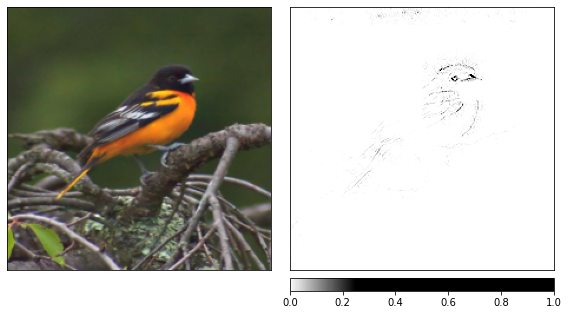

{'image': tensor([[[0.7255, 0.7255, 0.7255,  ..., 0.5333, 0.5294, 0.5216],
         [0.7255, 0.7255, 0.7255,  ..., 0.5255, 0.5255, 0.5216],
         [0.7216, 0.7216, 0.7216,  ..., 0.5255, 0.5255, 0.5216],
         ...,
         [0.4706, 0.4706, 0.4706,  ..., 0.3608, 0.3608, 0.3608],
         [0.4706, 0.4706, 0.4706,  ..., 0.3608, 0.3608, 0.3608],
         [0.4706, 0.4706, 0.4706,  ..., 0.3608, 0.3647, 0.3647]],

        [[0.7922, 0.7922, 0.7922,  ..., 0.5804, 0.5765, 0.5686],
         [0.7922, 0.7922, 0.7922,  ..., 0.5725, 0.5725, 0.5686],
         [0.7882, 0.7882, 0.7882,  ..., 0.5725, 0.5725, 0.5686],
         ...,
         [0.5176, 0.5176, 0.5176,  ..., 0.3843, 0.3804, 0.3804],
         [0.5176, 0.5176, 0.5176,  ..., 0.3843, 0.3804, 0.3804],
         [0.5176, 0.5176, 0.5176,  ..., 0.3843, 0.3843, 0.3843]],

        [[0.8627, 0.8627, 0.8627,  ..., 0.6431, 0.6392, 0.6314],
         [0.8627, 0.8627, 0.8627,  ..., 0.6353, 0.6353, 0.6314],
         [0.8588, 0.8588, 0.8588,  ..., 0.6353, 

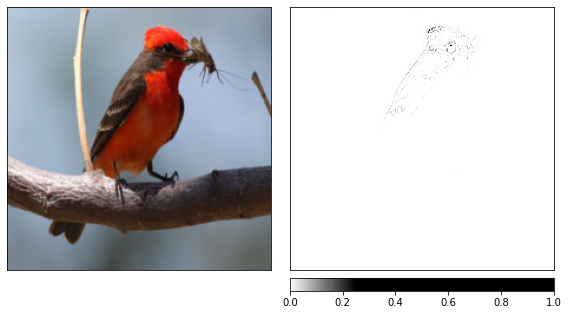

In [120]:
for i in range(10):
    gradCAM_model(mtt.model, np.random.choice(range(len(val_bird_dataset))), 'family')